### Cop1 Substrate priortization

This notebook is meant to priortize potential substrates of Cop1.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn import linear_model
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


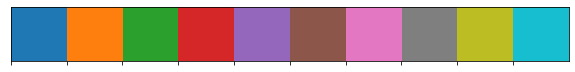

In [35]:
print(sns.color_palette().as_hex())
sns.palplot(sns.color_palette())


In [2]:
# read in the data
df = pd.read_csv('data/substrate_prioritization/Integrate_RNA_Protein.txt', sep='\t')
print(len(df))

# merged in adjusted values from RNA
rna_adj = pd.read_csv('data/degron_pred/diff_prot_abundance_RNA_adjusted.txt', sep='\t')
rename_dict = {
    'gene': 'Genes',
    'RNA adjusted t': 'Pro_no_treat_t_rnaAdj',
    'RNA adjusted pvalue': 'Pro_no_treat_P.Value_rnaAdj',
    'RNA adjusted qvalue': 'Pro_no_treat_adj.P.Val_rnaAdj'
}
rna_adj = rna_adj.rename(columns=rename_dict)

# read in RNA data
rna = pd.read_csv('data/substrate_prioritization/4t1_cop1_1-2_r26.txt', sep='\t')
rna = rna.reset_index().rename(columns={'stat': 'RNA wald-statistic', 'index': 'Genes'})

# merge data
mycols = ['Genes', 'Pro_no_treat_t_rnaAdj', 'Pro_no_treat_P.Value_rnaAdj', 'Pro_no_treat_adj.P.Val_rnaAdj']
df = pd.merge(df, rna_adj[mycols], on='Genes', how='left')
df = pd.merge(df, rna[['Genes', 'RNA wald-statistic']], on='Genes', how='left')
print(len(df))

# read in mouse TF genes
mouse_tf_df = pd.read_csv('data/substrate_prioritization/Mus_musculus_TF.txt', sep='\t')
mouse_tfs = mouse_tf_df['Symbol'].unique()

7369
7369


In [3]:
# filter based on differential protein abundance
is_signif = df['Pro_no_treat_adj.P.Val_rnaAdj']<0.1
is_up = df['Pro_no_treat_t_rnaAdj']>0
up_df = df[is_signif & is_up].copy()
print(up_df['Genes'].nunique())

532


### Volcano plot of transcription factors

In [4]:
# read in transcription factors from the AP-1 / ETS / CEBP family
tf_family = pd.read_csv('data/substrate_prioritization/tf_family_formatted.txt', sep='\t')
#tf_colors = {
#    'AP-1': sns.color_palette().as_hex()[0],
#    'CEBP': sns.color_palette().as_hex()[3],
#    'ETS': sns.color_palette().as_hex()[2]
#}
tf_colors = {
    'AP-1': sns.color_palette().as_hex()[4],
    'CEBP': sns.color_palette().as_hex()[1],
    'ETS': sns.color_palette().as_hex()[2]
}
tf_family.head()

,Mouse_Symbol,Human_Symbol,Family,Subfamily
0,Elf1,ELF1,ETS,ELF
1,Elf2,ELF2,ETS,ELF
2,Elf4,ELF4,ETS,ELF
3,Gabpa,GABPA,ETS,ELG
4,Erg,ERG,ETS,ERG


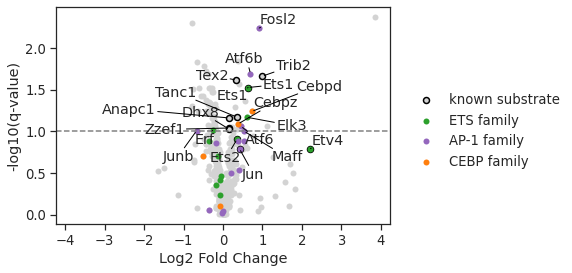

In [6]:
# all data
plot_df = df.copy().drop_duplicates('Genes')
plot_df['-log10(q-value)'] = -np.log10(df['Pro_no_treat_adj.P.Val_rnaAdj'])
plot_df['Log2 Fold Change'] = df['Pro_no_treat_logFC']
# good hits
#plot_df2 = up_motif_hscore_df.copy().drop_duplicates('Genes')
#plot_df2['-log10(q-value)'] = -np.log10(plot_df2['Pro_no_treat_adj.P.Val_rnaAdj'])
#plot_df2['Log2 Fold Change'] = plot_df2['Pro_no_treat_logFC']
# plot results
txt_lbls = []
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    known_cases = ['Ets1', 'Ets2', 'Jun', 'Etv4', 'Trib2', 'Tex2', 'Anapc1', 'Tanc1', 'Zzef1', 'Dhx8']
    ax = sns.scatterplot(x='Log2 Fold Change', y='-log10(q-value)', data=plot_df[plot_df['Genes'].isin(list(mouse_tfs) + known_cases)], linewidth=0, color='lightgray')
    #ax = sns.scatterplot(x='Log2 Fold Change', y='-log10(q-value)', data=plot_df2, linewidth=1, color='red', edgecolor=None, label='high scoring Cop1 motif')
    #txt_lbls+=[
    #    ax.text(row['Log2 Fold Change'], row['-log10(q-value)'], row['Genes'])
    #    for ix, row in plot_df2.iterrows()
    #]
    # label known/predicted substrates
    sns.scatterplot(x='Log2 Fold Change', y='-log10(q-value)', data=plot_df[plot_df['Genes'].isin(known_cases)], linewidth=1.5, color='lightgray', edgecolor='black', label='known substrate')
    txt_lbls+=[
        ax.text(row['Log2 Fold Change'], row['-log10(q-value)'], row['Genes'])
        for ix, row in plot_df[plot_df['Genes'].isin(known_cases)].iterrows()
    ]
    # label TFs
    known_cases = tf_family[tf_family['Family']=='ETS']['Mouse_Symbol'].values
    sns.scatterplot(x='Log2 Fold Change', y='-log10(q-value)', data=plot_df[plot_df['Genes'].isin(known_cases)], linewidth=0, color=tf_colors['ETS'], label='ETS family')
    txt_lbls+=[
        ax.text(row['Log2 Fold Change'], row['-log10(q-value)'], row['Genes'])
        for ix, row in plot_df[plot_df['Genes'].isin(known_cases)].iterrows()
        if row['-log10(q-value)']>1
    ]
    known_cases = tf_family[tf_family['Family']=='AP-1']['Mouse_Symbol'].values
    sns.scatterplot(x='Log2 Fold Change', y='-log10(q-value)', data=plot_df[plot_df['Genes'].isin(known_cases)], linewidth=0, color=tf_colors['AP-1'], label='AP-1 family')
    txt_lbls+=[
        ax.text(row['Log2 Fold Change'], row['-log10(q-value)'], row['Genes'])
        for ix, row in plot_df[plot_df['Genes'].isin(known_cases)].iterrows()
        if row['-log10(q-value)']>1
    ]
    cebp_family = tf_family[tf_family['Family']=='CEBP']['Mouse_Symbol'].values 
    sns.scatterplot(x='Log2 Fold Change', y='-log10(q-value)', data=plot_df[plot_df['Genes'].isin(cebp_family)], linewidth=0, color=tf_colors['CEBP'], edgecolor=None, label='CEBP family')
    txt_lbls+=[
        ax.text(row['Log2 Fold Change'], row['-log10(q-value)'], row['Genes'])
        for ix, row in plot_df[plot_df['Genes'].isin(cebp_family)].iterrows()
        if row['-log10(q-value)']>1
    ]
    
    # set x limits
    plt.xlim(-4.25, 4.25)

    # configure other plotting options
    plt.axhline(1, ls='--', color='gray')
    plt.legend(bbox_to_anchor=(1.05, .63), loc=2, borderaxespad=0., frameon=False, )
    import adjustText
    adjustText.adjust_text(txt_lbls, arrowprops=dict(arrowstyle='-', color='black'))
    #plt.savefig('figures/proteomics_volcano_all_tfs_v4.pdf')

### Plot degron motif hits

Next, we filter by degron sequence motif

In [8]:
is_motif = up_df['degron']=='yes'
up_motif_df = up_df[is_motif].copy()
print(up_motif_df['Genes'].nunique())
up_motif_df['Genes'].unique()

39


array(['Pdgfrl', 'Trib2', 'Mgat5', 'Cebpd', 'Ets1', 'Rap1gap', 'Spn',
       'Cpd', 'Flt1', 'Dtnb', 'Trib3', 'Serac1', 'Lamp1', 'Ufc1', 'Nbr1',
       'Map4k4', 'Apbb1ip', 'Tanc1', 'Tex2', 'Mtr', 'Diexf', 'Smtn',
       'Fbxw8', 'Fez2', 'Dock11', 'Rab11fip1', 'Akap12', 'Ercc3',
       'Tango6', 'Ctsd', 'Cmtr1', 'Sh3glb2', 'Npat', 'Gtse1', 'Eif4g3',
       'Zzef1', 'Dhx8', 'Anapc1', 'Plekhm1'], dtype=object)

Next, only motifs in humans and higher degron potential

In [9]:
is_high_score = up_motif_df['Random Forest score']>0.5
up_motif_hscore_df = up_motif_df[is_high_score].copy()
print(up_motif_hscore_df['Genes'].nunique())
is_high_lfc = df['Pro_no_treat_logFC']>0.5
up_motif_hscore_df['Genes'].unique()

7


array(['Trib2', 'Ets1', 'Tanc1', 'Tex2', 'Zzef1', 'Dhx8', 'Anapc1'],
      dtype=object)

In [16]:
# all data
plot_df = df.copy().drop_duplicates('Genes')
plot_df['-log10(q-value)'] = -np.log10(df['Pro_no_treat_adj.P.Val_rnaAdj'])
plot_df['Log2 Fold Change'] = df['Pro_no_treat_logFC']

Next, we plot the volcano plot for differential expression.

/Users/ctokheim/conda/envs/data_analysis2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


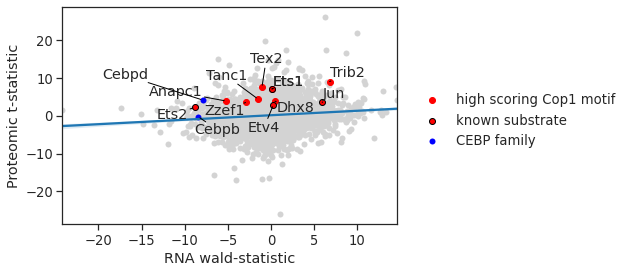

In [20]:
# plot results
# all data
plot_df = df.copy().drop_duplicates('Genes')
plot_df['Proteomic t-statistic'] = plot_df['Pro_no_treat_t']
# good hits
plot_df2 = up_motif_hscore_df.copy().drop_duplicates('Genes')
plot_df2['Proteomic t-statistic'] = plot_df2['Pro_no_treat_t']
txt_lbls = []
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.scatterplot(x='RNA wald-statistic', y='Proteomic t-statistic', data=plot_df, linewidth=0, color='lightgray')
    ax = sns.scatterplot(x='RNA wald-statistic', y='Proteomic t-statistic', data=plot_df2, linewidth=1, color='red', edgecolor=None, label='high scoring Cop1 motif')
    txt_lbls+=[
        ax.text(row['RNA wald-statistic'], row['Proteomic t-statistic'], row['Genes'])
        for ix, row in plot_df2.iterrows()
    ]
    known_cases = ['Ets1', 'Ets2', 'Jun', 'Etv4']
    sns.scatterplot(x='RNA wald-statistic', y='Proteomic t-statistic', data=plot_df[plot_df['Genes'].isin(known_cases)], linewidth=1, color='red', edgecolor='black', label='known substrate')
    txt_lbls+=[
        ax.text(row['RNA wald-statistic'], row['Proteomic t-statistic'], row['Genes'])
        for ix, row in plot_df[plot_df['Genes'].isin(known_cases)].iterrows()
    ]
    cebp_family = ['Cebpa', 'Cebpb', 'Cebpc', 'Cebpd', 'Cebpe'] 
    sns.scatterplot(x='RNA wald-statistic', y='Proteomic t-statistic', data=plot_df[plot_df['Genes'].isin(cebp_family)], linewidth=0, color='blue', edgecolor=None, label='CEBP family')
    txt_lbls+=[
        ax.text(row['RNA wald-statistic'], row['Proteomic t-statistic'], row['Genes'])
        for ix, row in plot_df[plot_df['Genes'].isin(cebp_family)].iterrows()
    ]
    # configure other plotting options
    plt.legend(bbox_to_anchor=(1.05, .63), loc=2, borderaxespad=0., frameon=False, )
    import adjustText
    adjustText.adjust_text(txt_lbls, arrowprops=dict(arrowstyle='-', color='black'))
    sns.regplot('RNA wald-statistic', 'Proteomic t-statistic', scatter=False, data=plot_df)
    #plt.savefig('figures/rna_prot_correlation.pdf')

### Proteomic heatmap

In [21]:
# read in protein abundance
prot_abundance = pd.read_csv('data/substrate_prioritization/protein_abundance.txt', sep='\t').rename(columns={'Gene': 'MouseSymbol'}).drop_duplicates('MouseSymbol')
samples = prot_abundance.columns[1:]

# merge in info about significance
df['significant'] = 'lightgray'
is_signif = df['Pro_no_treat_adj.P.Val_rnaAdj']<=0.1
is_up = df['Pro_no_treat_t_rnaAdj']>0
df.loc[is_signif & is_up, 'significant'] = sns.color_palette().as_hex()[2]
prot_abundance = pd.merge(prot_abundance, df[['Genes', 'significant']], 
                          left_on='MouseSymbol', right_on='Genes', how='left')

# Get the list of TF genes up-regulated
tmp_signif_up = df.loc[is_signif & is_up, 'Genes']
signif_up_tfs = tf_family.loc[tf_family['Mouse_Symbol'].isin(tmp_signif_up), 'Mouse_Symbol']
signif_up_tfs

12     Ets1
23     Elk3
30    Cebpd
32    Cebpz
35    Fosl2
43     Atf6
44    Atf6b
53     Maff
Name: Mouse_Symbol, dtype: object

In [24]:
prot_abundance

,MouseSymbol,Rosa26_r1 No treatment,Rosa26_r2 No treatment,Cop1_sg1_r1 No treatment,Cop1_sg1_r2 No treatment,Cop1_sg2_r1 No treatment,Cop1_sg2_r2 No treatment,Rosa26_r1 MG132 treat,Rosa26_r2 MG132 treat,Cop1_sg1_r1 MG132 treat,Cop1_sg1_r2 MG132 treat,Cop1_sg2_r1 MG132 treat,Genes,significant
0,Ahnak,10.48200,10.81400,10.21720,9.25378,8.42749,8.34256,9.61722,8.26120,9.19947,8.62662,6.75847,Ahnak,lightgray
1,Plec,9.70880,9.35968,8.72549,7.99173,10.55530,9.60815,8.21902,7.13901,9.32669,9.13145,10.23470,Plec,lightgray
2,Dync1h1,9.91839,10.78580,8.39088,8.22774,9.08761,8.70211,9.50084,8.53565,8.49539,8.88014,9.47550,Dync1h1,lightgray
3,Eef1a1,8.05028,9.93620,8.46026,10.82350,9.66216,11.37630,7.24741,10.29010,7.42588,8.52540,8.20254,Eef1a1,lightgray
4,Pkm,9.19546,9.19652,9.60625,8.94649,9.72321,10.39180,8.47904,9.67649,8.12013,7.59412,9.07051,Pkm,lightgray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,Edem2,9.90355,8.17316,8.32577,10.29870,8.91208,8.99317,9.26181,8.83450,9.50155,9.57957,8.21616,Edem2,lightgray
7786,Zfp451,8.06164,8.53396,7.18999,6.38257,6.75549,4.94803,12.95960,10.70440,12.68240,11.39590,10.38600,Zfp451,lightgray
7787,Serpinb9b,7.27882,7.35151,14.60490,12.88340,8.45875,7.56624,6.16968,6.65048,11.02840,9.98096,8.02686,Serpinb9b,lightgray
7788,Igtp,8.30344,9.48992,10.21560,7.03404,9.94691,10.23660,9.49595,10.00290,7.97356,7.67429,9.62677,Igtp,lightgray


In [31]:
#samps_no_treat = ["Cop1_sg1_r1 No treatment", "Cop1_sg1_r2 No treatment", "Cop1_sg2_r1 No treatment", "Cop1_sg2_r2 No treatment"]
#samps_treat = ["Cop1_sg1_r1 MG132 treat", "Cop1_sg1_r2 MG132 treat"]
#cop1_mg132_fc = plot_df[samps_treat].mean(axis=1) / plot_df[samps_no_treat].mean(axis=1)
tmp = prot_abundance[prot_abundance['MouseSymbol'].isin(list(tf_family['Mouse_Symbol'].unique()))].copy()
tmp['TF family'] = tf_colors['AP-1']
tmp.loc[tmp['MouseSymbol'].isin(tf_family[tf_family['Family']=='ETS']['Mouse_Symbol']), 'TF family'] = tf_colors['ETS']
tmp.loc[tmp['MouseSymbol'].isin(tf_family[tf_family['Family']=='CEBP']['Mouse_Symbol']), 'TF family'] = tf_colors['CEBP']
plot_df = tmp.set_index('MouseSymbol').loc[list(signif_up_tfs)]

samps_no_treat = ["Rosa26_r1 No treatment", "Rosa26_r2 No treatment"]
samps_treat = ["Rosa26_r1 MG132 treat", "Rosa26_r2 MG132 treat"]
#plot_df[samps_treat].median(axis=1) / plot_df[samps_no_treat].median(axis=1)
tvec = []
pvec = []
for ix, row in plot_df.iterrows():
    t, pval = stats.ttest_ind(row[samps_treat], row[samps_no_treat], equal_var=False)
    tvec.append(t)
    pvec.append(pval)
tmp_df = pd.DataFrame({'t statistic': tvec, 'pvalue': pvec}, index=plot_df.index)
tmp_df

,t statistic,pvalue
MouseSymbol,,
Ets1,8.227744,0.018762
Elk3,-0.302278,0.801983
Cebpd,18.657922,0.030743
Cebpz,1.211661,0.364314
Fosl2,1.813070,0.303564
Atf6,8.281545,0.050926
Atf6b,8.511109,0.015701
Maff,2.934127,0.103452


In [32]:
samps_no_treat = ["Cop1_sg1_r1 No treatment", "Cop1_sg1_r2 No treatment", "Cop1_sg2_r1 No treatment", "Cop1_sg2_r2 No treatment"]
samps_treat = ["Cop1_sg1_r1 MG132 treat", "Cop1_sg1_r2 MG132 treat", "Cop1_sg2_r1 MG132 treat"]
#plot_df[samps_treat].median(axis=1) / plot_df[samps_no_treat].median(axis=1)
tvec = []
pvec = []
for ix, row in plot_df.iterrows():
    t, pval = stats.ttest_ind(row[samps_treat], row[samps_no_treat], equal_var=False)
    tvec.append(t)
    pvec.append(pval)
tmp_df2 = pd.DataFrame({'t statistic': tvec, 'pvalue': pvec}, index=plot_df.index)
tmp_df2.head()

,t statistic,pvalue
MouseSymbol,,
Ets1,4.732656,0.027964
Elk3,-0.174314,0.868730
Cebpd,0.902379,0.421658
Cebpz,-1.828841,0.129829
Fosl2,-1.186895,0.331632


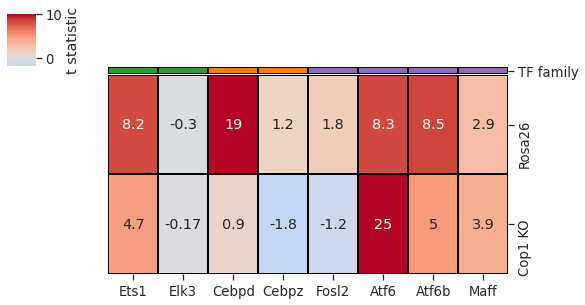

In [33]:
is_constant = plot_df.std(axis=1)==0
col_colors = plot_df.loc[~is_constant, ['TF family']].copy()
plot_df2 = pd.DataFrame({'Rosa26': tmp_df['t statistic'], 'Cop1 KO': tmp_df2['t statistic']})
with sns.plotting_context('notebook', font_scale=1.2), sns.axes_style('ticks'):
    g = sns.clustermap(plot_df2.T.loc[['Rosa26', 'Cop1 KO']], cmap='coolwarm', center=0, #z_score=1, 
       annot=True, cbar_kws={'label':'t statistic'}, xticklabels=True, col_colors=col_colors,
       linewidth=1, linecolor='black',
       col_cluster=False, row_cluster=False, vmax=10
       #col_colors=[sns.color_palette()[2] if l=='yes' else sns.color_palette()[5] for l in degron_labels]
    )
    plt.gcf().set_size_inches(8, 4)
    g.ax_heatmap.set_xlabel('')
    #plt.savefig('figures/mg132_treatment_heatmap.pdf')